In [1]:
# Setup imports and path so `src` package is importable
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import logging
# Reduce TensorFlow logging to suppress known deprecation warnings from TF and TFP
# Set C++ minimal log level (0=all,1=INFO,2=WARNING,3=ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Reduce Python-side TensorFlow logger verbosity
try:
    tf.get_logger().setLevel(logging.ERROR)
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    # Also set v1 logging verbosity if available
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

# ensure the project root is on sys.path so `src` is importable
# project_root = r"C:\Users\yecha\workspace\JPMSummer"
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

from src.data.data import SSMData, StochasticVariationalData
from src.models.KalmanFilter import KalmanFilter
from src.models.ExtendedKalmanFilter import ExtendedKalmanFilter
from src.models.UnscentedKalmanFilter import UnscentedKalmanFilter
from src.models.ParticleFilter import ParticleFilter

import tensorflow_probability as tfp
tfd = tfp.distributions

tf.random.set_seed(1)
np.random.seed(1)

## 1) Multidimensional linear Gaussian SSM and Kalman Filter

We construct a 2D constant-velocity system (state = [position, velocity]) and observe position and velocity with noise.

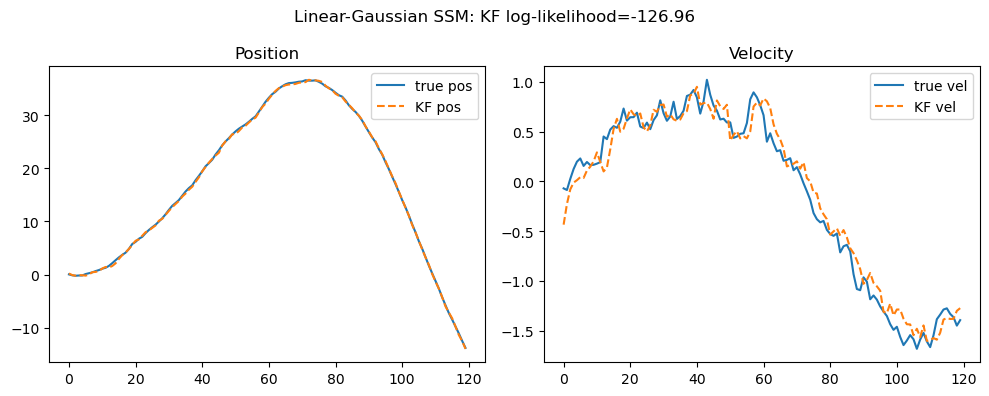

In [2]:
# Build a simple 2D constant-velocity model
dt = 1.0
A = np.array([[1.0, dt], [0.0, 1.0]], dtype=float)  # transition
H = np.eye(2, dtype=float)  # observe both states
Q = np.eye(2, dtype=float) * 0.01  # small process noise
R = np.eye(2, dtype=float) * 0.1   # observation noise

T = 120
initial_mean = np.zeros((2,))
initial_cov = np.eye(2) * 1.0

ssm = SSMData(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dtype=tf.float64,
)

x_true_tf, y_tf = ssm.sample(num_steps=T, seed=42)
# Convert to numpy for plotting/feeding non-tf filters
x_true = x_true_tf.numpy()  # shape (T+1, state_dim)
y = y_tf.numpy()            # shape (T, obs_dim)

# Run Kalman Filter
kf = KalmanFilter(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
)

filtered_means_tf, filtered_covs_tf, ll = kf.filter(tf.convert_to_tensor(y, dtype=tf.float64))
filtered_means = filtered_means_tf.numpy()

# Plot true vs filtered
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_true[1:, 0], label='true pos')
plt.plot(filtered_means[:, 0], '--', label='KF pos')
plt.title('Position')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_true[1:, 1], label='true vel')
plt.plot(filtered_means[:, 1], '--', label='KF vel')
plt.title('Velocity')
plt.legend()
plt.suptitle(f'Linear-Gaussian SSM: KF log-likelihood={float(ll):.2f}')
plt.tight_layout()
plt.show()

## 2) Generate stochastic variational dataset

We use the `StochasticVariationalData` class (1D) added to `data.py`.
Model (1D):
- X_k = alpha * X_{k-1} + sigma * eta_k  (eta_k ~ N(0,1))
- Y_k = beta * exp(X_k / 2) * epsilon_k (epsilon_k ~ N(0,1))

We'll simulate a series and visualize the latent log-volatility X and observations Y.

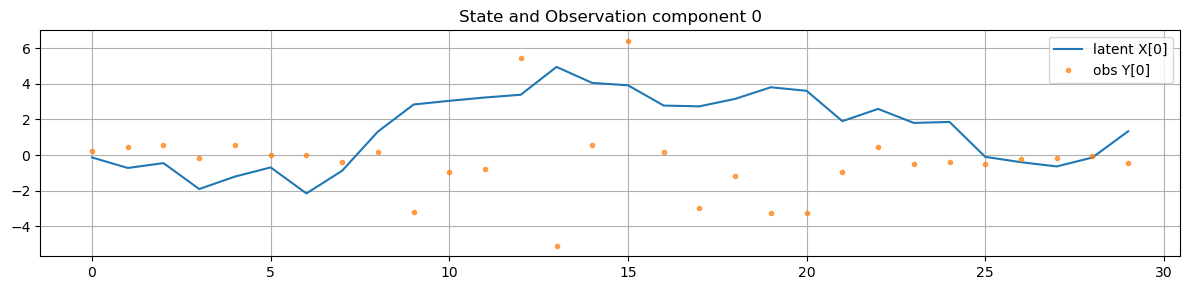

In [3]:
# Parameters for stochastic variational (stochastic volatility-like) model
alpha = 0.91
sigma = 1
beta = 0.5
T_sv = 30
n_state = 1
n_obs = 1
num_particles = 100
seed = 42

sv = StochasticVariationalData(alpha=alpha, 
                               sigma=sigma, 
                               beta=beta, 
                               n_state=n_state,
                               n_obs=n_obs,
                            #    initial_state=0.0, 
                               dtype=tf.float64)
x_sv_tf, y_sv_tf = sv.sample(num_steps=T_sv, seed=seed)
# x_sv: shape (T+1, n_state), y_sv: shape (T, n_obs)
x_sv = x_sv_tf.numpy()  # shape (T+1, n_state)
y_sv = y_sv_tf.numpy()  # shape (T, n_obs)

# Plot latent state components and observations together (one subplot per index)
import os
os.makedirs('figures', exist_ok=True)
n_plots = max(1, max(n_state, n_obs))
plt.figure(figsize=(12, 3 * n_plots))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i + 1)
    if i < n_state:
        plt.plot(x_sv[1:, i], '-', label=f'latent X[{i}]')
    if i < n_obs:
        plt.plot(y_sv[:, i], '.', alpha=0.7, label=f'obs Y[{i}]')
    plt.title(f'State and Observation component {i}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
# Save combined figure
# plt.savefig(os.path.join('figures', 'sv_states_and_obs.pdf'), bbox_inches='tight')
plt.show()

In [4]:
import tensorflow as tf


def f(x: tf.Tensor) -> tf.Tensor:
    # Support scalar or per-dimension `alpha` and both vector/batch inputs
    x = tf.cast(x, dtype=tf.float64)
    a = tf.cast(alpha, dtype=tf.float64)
    return a * x


def h(x: tf.Tensor) -> tf.Tensor:
    # Elementwise volatility transform: beta * exp(x/2).
    # Accepts vector (n_state,) or batch (N, n_state). If an observation
    # matrix `C` is present in the notebook namespace, map the per-state
    # contributions into observation space: y = C @ z.
    x = tf.cast(x, dtype=tf.float64)
    b = tf.cast(beta, dtype=tf.float64)
    z = b * tf.exp(x / 2.0)
    return z


# Approximate observation covariance R and process covariance Q for multivariate state
# Ensure beta and sigma are vectors of length n_state for per-dimension scaling
beta_vec = np.asarray(beta) if np.ndim(beta) > 0 else np.full((n_state,), float(beta))
sigma_vec = np.asarray(sigma) if np.ndim(sigma) > 0 else np.full((n_state,), float(sigma))
# # x_sv has shape (T+1, n_state); use time indices 1..T to compute empirical mean
# emp_R_diag = (beta_vec ** 2) * np.mean(np.exp(x_sv[1:, :]), axis=0)
# R_approx = np.diag(emp_R_diag).astype(float)
Q_approx = 0.5 * np.eye(n_state)
R_approx = 0.5 * np.eye(n_state)

# Initial conditions
initial_mean = np.zeros((n_state,))
initial_cov = np.eye(n_state)

print("Approximate R:", R_approx)
print("Approximate Q:", Q_approx)
print("initial_mean:", initial_mean)
print("initial_cov:", initial_cov)

Approximate R: [[0.5]]
Approximate Q: [[0.5]]
initial_mean: [0.]
initial_cov: [[1.]]


## 3) Apply EKF & UKF to stochastic variational data (approximation)

We construct deterministic functions:
- f(x) = alpha * x  (transition mean)
- h(x) = beta * exp(x / 2)  (observation *scale* so actual observation is h(x) * epsilon)

Both EKF and UKF implementations assume additive observation noise y = h(x) + r with fixed covariance R. For this experiment we approximate the observation noise with a fixed scalar variance chosen as the empirical mean of beta^2 * exp(x). This is an approximation to make EKF/UKF run without changing their APIs. Particle filter (next) will use multiplicative noise naturally.

In [5]:
from src.models.PFPF import EDH_ParticleFlowPF, LEDH_ParticleFlowPF
from src.models.KernelFlow import KernelScalarFlow, KernelMatrixFlow
from src.models.EDH import EDH, LEDH

KernelScalarFlow.filter step=1 mean=[-0.082] loglik=-0.6957847436503437
KernelScalarFlow.filter step=2 mean=[-0.099] loglik=-0.622894815284881
KernelScalarFlow.filter step=2 mean=[-0.099] loglik=-0.622894815284881
KernelScalarFlow.filter step=3 mean=[-0.106] loglik=-0.6187130627259956
KernelScalarFlow.filter step=3 mean=[-0.106] loglik=-0.6187130627259956
KernelScalarFlow.filter step=4 mean=[-0.148] loglik=-0.990519156663737
KernelScalarFlow.filter step=4 mean=[-0.148] loglik=-0.990519156663737
KernelScalarFlow.filter step=5 mean=[-0.15] loglik=-0.6066266669299987
KernelScalarFlow.filter step=5 mean=[-0.15] loglik=-0.6066266669299987
KernelScalarFlow.filter step=6 mean=[-0.178] loglik=-0.8041443406721083
KernelScalarFlow.filter step=6 mean=[-0.178] loglik=-0.8041443406721083
KernelScalarFlow.filter step=7 mean=[-0.213] loglik=-0.7938600307584016
KernelScalarFlow.filter step=7 mean=[-0.213] loglik=-0.7938600307584016
KernelScalarFlow.filter step=8 mean=[-0.266] loglik=-1.235971973327678

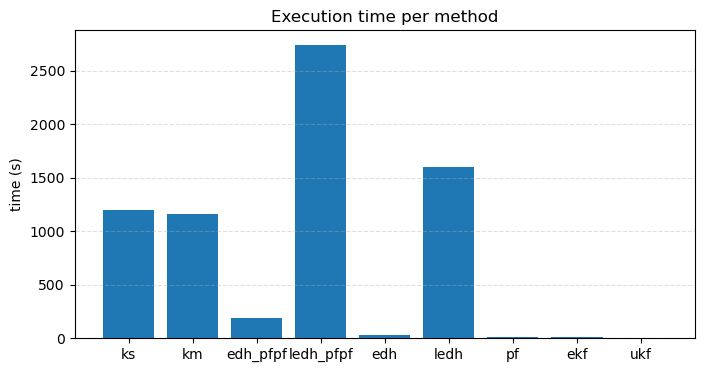

In [ ]:
verbose = True
# Create EKF and UKF instances
sv_ekf = ExtendedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

sv_ukf = UnscentedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

# PF for stochastic volatility
sv_pf = ParticleFilter(
    transition_fn=f,
    observation_fn=h,  # Original observation function for PF
    Q=Q_approx,
    R=R_approx,  # Original observation noise for PF
    num_particles=num_particles,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    seed=42,
)


# Prior particle cloud (Gaussian)
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(n_state, dtype=tf.float64), scale_diag=tf.ones(n_state, dtype=tf.float64))

particles_edh = prior.sample(num_particles)
particles_ledh = prior.sample(num_particles)

particles_edh_pfpf = prior.sample(num_particles)
particles_ledh_pfpf = prior.sample(num_particles)

particles_ks = prior.sample(num_particles)
particles_km = prior.sample(num_particles)


# Initialize EDH/LEDH filters with the sampled particles
sv_edh = EDH(num_particles,
            f = f,
            h = h,
            state_dim = n_state,
            observation_dim = n_obs,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
sv_edh.initialize(particles = particles_edh)

sv_ledh = LEDH(num_particles,
            f = f,
            h = h,
            state_dim = n_state,
            observation_dim = n_obs,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
sv_ledh.initialize(particles = particles_ledh)

pf_ledh = LEDH_ParticleFlowPF(num_particles, 
                                f=f, 
                                h=h, 
                                state_dim=n_state, 
                                observation_dim=n_obs, 
                                R=R_approx, 
                                Q=Q_approx, 
                                dtype=tf.float64)
pf_edh = EDH_ParticleFlowPF(num_particles, 
                            f=f, 
                            h=h, 
                            state_dim=n_state, 
                            observation_dim=n_obs, 
                            R=R_approx, 
                            Q=Q_approx, 
                            dtype=tf.float64)

pf_ledh.initialize(particles=particles_ledh_pfpf)
pf_edh.initialize(particles=particles_edh_pfpf)


ks = KernelScalarFlow(n_flow_steps=10)
km = KernelMatrixFlow(n_flow_steps=10)


sv_ledh.n_flow_steps = 10
sv_edh.n_flow_steps = 10
pf_ledh.n_flow_steps = 10
pf_edh.n_flow_steps = 10

# Run EKF and UKF on the observations
obs = tf.convert_to_tensor(y_sv.reshape(-1, 1), dtype=tf.float64)

# Ensure observation matrix matches stochastic-variational dims (1x1)
H_sv = np.eye(n_obs)

# Use R_approx (1x1) for the stochastic-variational experiment, not the earlier 2x2 `R`.
# Time each method and store durations (seconds)
times = {}
t0 = time.perf_counter()
ks_means, ks_covs, ks_ll = ks.filter(obs.numpy(), particles_ks, h, R_approx, H_sv, verbose = verbose)
times['ks'] = time.perf_counter() - t0
t0 = time.perf_counter()
km_means, km_covs, km_ll = km.filter(obs.numpy(), particles_km, h, R_approx, H_sv, verbose = verbose)
times['km'] = time.perf_counter() - t0
t0 = time.perf_counter()
edh_pfpf_means_tf, edh_pf_covs_tf, edh_pf_ll = pf_edh.filter(obs, verbose = verbose)
times['edh_pfpf'] = time.perf_counter() - t0
t0 = time.perf_counter()
ledh_pfpf_means_tf, ledh_pf_covs_tf, ledh_pf_ll = pf_ledh.filter(obs)
times['ledh_pfpf'] = time.perf_counter() - t0
t0 = time.perf_counter()
edh_means_tf, edh_covs_tf, edh_ll = sv_edh.filter(obs, verbose = verbose)
times['edh'] = time.perf_counter() - t0
t0 = time.perf_counter()
ledh_means_tf, ledh_covs_tf, ledh_ll = sv_ledh.filter(obs)
times['ledh'] = time.perf_counter() - t0
t0 = time.perf_counter()
pf_means_tf, pf_covs_tf, pf_ll = sv_pf.filter(obs)
times['pf'] = time.perf_counter() - t0
t0 = time.perf_counter()
ekf_means_tf, ekf_covs_tf, ekf_ll = sv_ekf.filter(obs)
times['ekf'] = time.perf_counter() - t0
t0 = time.perf_counter()
ukf_means_tf, ukf_covs_tf, ukf_ll = sv_ukf.filter(obs)
times['ukf'] = time.perf_counter() - t0


sv_ks_means = ks_means.numpy().squeeze()
sv_km_means = km_means.numpy().squeeze()
sv_pf_means = pf_means_tf.numpy().squeeze()
sv_ekf_means = ekf_means_tf.numpy().squeeze()
sv_ukf_means = ukf_means_tf.numpy().squeeze()
sv_edh_means = edh_means_tf.numpy().squeeze()
sv_ledh_means = ledh_means_tf.numpy().squeeze()
sv_edh_pfpf_means = edh_pfpf_means_tf.numpy().squeeze()
sv_ledh_pfpf_means = ledh_pfpf_means_tf.numpy().squeeze()   
# Print timing summary and save a bar plot
print('Method timings (s):')
for k, v in times.items():
    print(f'{k}: {v:.4f}')




Average RMSE (using x_sv[1:] as truth):
EKF: 4.7618
UKF: 4.9291
PF: 3.4009
EDH: 5.4752
LEDH: 5.7650
PFPF_EDH: 4.3542
PFPF_LEDH: 3.5822
KS: 2.8400
KM: 2.6408


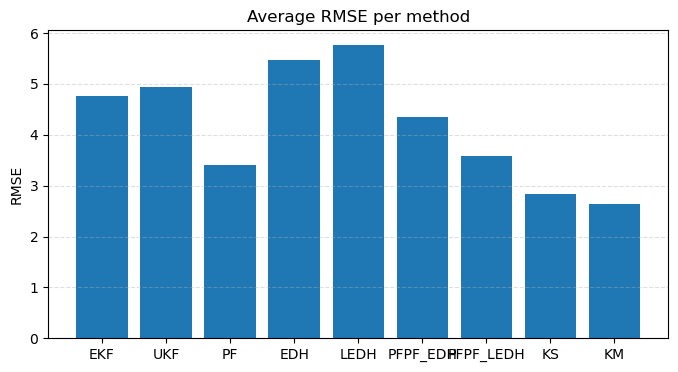

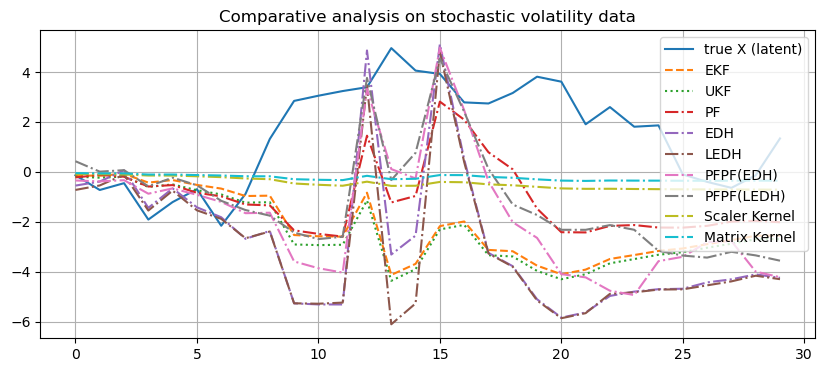

Method timings (s):
ks: 39.9961
km: 38.7859
edh_pfpf: 6.1810
ledh_pfpf: 91.3986
edh: 1.1218
ledh: 53.3130
pf: 0.2824
ekf: 0.2318
ukf: 0.0633


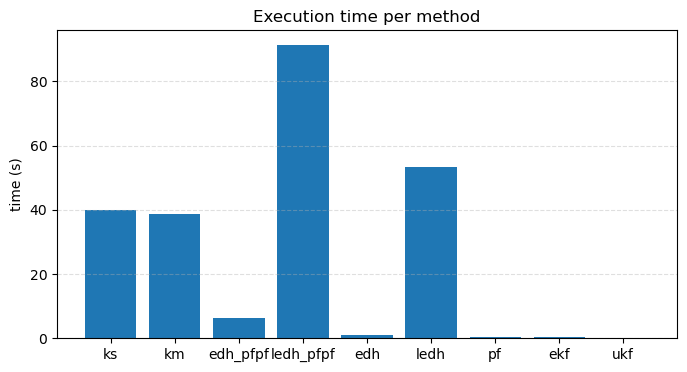

In [11]:
# Compute average RMSE (using x_sv[1:] as ground truth)
truth = np.asarray(x_sv[1:])
# Ensure truth has shape (T, n_state)
if truth.ndim == 1:
    truth = truth.reshape(-1, 1)
methods = {
    'EKF': sv_ekf_means,
    'UKF': sv_ukf_means,
    'PF': sv_pf_means,
    'EDH': sv_edh_means,
    'LEDH': sv_ledh_means,
    'PFPF_EDH': sv_edh_pfpf_means,
    'PFPF_LEDH': sv_ledh_pfpf_means,
    'KS': sv_ks_means,
    'KM': sv_km_means,
}
rmse = {}
for name, arr in methods.items():
    a = np.asarray(arr)
    # reshape 1-D estimates into (T, n_state) when needed
    if a.ndim == 1:
        a = a.reshape(-1, truth.shape[1])
    # If array has extra trailing dims, try to squeeze to (T, n_state)
    if a.ndim > 2:
        a = np.reshape(a, (a.shape[0], -1))
    # compute RMSE over time and state dims
    err = a - truth
    rmse_val = np.sqrt(np.mean(err ** 2))
    rmse[name] = float(rmse_val)
# Print results
print('Average RMSE (using x_sv[1:] as truth):')
for k, v in rmse.items():
    print(f'{k}: {v:.4f}')
# Save bar plot of RMSEs
import os
os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(8, 4))
labels = list(rmse.keys())
vals = [rmse[k] for k in labels]
plt.bar(labels, vals, color='C0')
plt.ylabel('RMSE')
plt.title('Average RMSE per method')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig(os.path.join('figures', 'sv_methods_rmse.pdf'), bbox_inches='tight')
plt.show()
# Then show the comparative time-series plot as before
plt.figure(figsize=(10, 4))
plt.plot(x_sv[1:], label='true X (latent)')
# plt.plot(y_sv[1:], label='Y (observed)')
plt.plot(sv_ekf_means, '--', label='EKF')
plt.plot(sv_ukf_means, ':', label='UKF')
plt.plot(sv_pf_means, '-.', label='PF')
plt.plot(sv_edh_means, '-.', label='EDH')
plt.plot(sv_ledh_means, '-.', label='LEDH')
plt.plot(sv_edh_pfpf_means, '-.', label='PFPF(EDH)')
plt.plot(sv_ledh_pfpf_means, '-.', label='PFPF(LEDH)')
plt.plot(sv_ks_means, '-.', label='Scaler Kernel')
plt.plot(sv_km_means, '-.', label='Matrix Kernel')
plt.grid(True)
plt.legend()
plt.title('Comparative analysis on stochastic volatility data')
os.makedirs('figures', exist_ok=True)
plt.savefig(os.path.join('figures', 'sv_filters_compare.pdf'), bbox_inches='tight')
plt.show()


print('Method timings (s):')
for k, v in times.items():
    print(f'{k}: {v/T_sv:.4f}')

os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(8, 4))
labels = list(times.keys())
vals = [times[k]/T_sv for k in labels]
plt.bar(labels, vals)
plt.ylabel('time (s)')
plt.title('Execution time per method')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig(os.path.join('figures', 'sv_methods_times.pdf'), bbox_inches='tight')
plt.show()


## 4) Particle Filter on the stochastic variational data

The Particle Filter can directly handle multiplicative observation noise by using the deterministic observation function `h(x) = beta * exp(x/2)` and evaluating the likelihood p(y | x) = Normal(loc=0, scale=h(x)). We'll set a reasonably large number of particles for stability.